In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import cvxpy as cp
from sklearn.covariance import LedoitWolf
from tqdm import tqdm

In [2]:
Static = pd.read_excel("./Data_new/Static.xlsx")

# EScore = pd.read_excel("./Data/DS_EScore_Y.xlsx")
# SScore = pd.read_excel("./Data/DS_SScore_Y.xlsx")
GScore = pd.read_excel("./Data_new/DS_GScore_Y.xlsx")
# ESGScore = pd.read_excel("./Data/DS_ESGScore_Y.xlsx")

RI_m = pd.read_excel("./Data_new/DS_RI_USD_M.xlsx").iloc[:, :-1]
# RI_y = pd.read_excel("./Data/DS_RI_USD_Y.xlsx")
MC_m = pd.read_excel("./Data_new/DS_MV_USD_M.xlsx").iloc[:, :-1]
# MC_y = pd.read_excel("./Data/DS_MV_USD_Y.xlsx")
REV_y = pd.read_excel("./Data_new/DS_REV_USD_Y.xlsx")

# Scope1 = pd.read_excel("./Data/Scope_1.xlsx")
# Scope2 = pd.read_excel("./Data/Scope_2.xlsx")


In [3]:
time = RI_m.iloc[:, 3:].columns # extract the timestamp index
RF_m = pd.read_excel("./Data_new/Risk_Free_Rate.xlsx", index_col=0)
RF_m = RF_m / 100
RF_m.index = time
RF_m = RF_m.T
RF_m.reset_index(drop=True, inplace=True)

# extract 2014-2024
RF_m_temp_original = RF_m.loc[:, (RF_m.columns >= pd.Timestamp("2014-01-01")) & (RF_m.columns <= pd.Timestamp("2024-12-31"))]
RF_m_temp = RF_m_temp_original.T

In [4]:
# Filter the firms:
# Condition 1: Europe
# Condition 2: GScore data avaiable
GScore_merged = GScore.merge(Static, on="ISIN")
GScore_eur = GScore_merged.loc[GScore_merged["Region"] == "EUR"].copy()
# GScore_eur.dropna(subset=[GScore_eur.columns[x] for x in range(16, 27)], inplace=True)

In [5]:
# Our dataset of group7
RI_m_eur = RI_m.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")
# RI_y_eur = RI_y.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")
MC_m_eur = MC_m.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")
# MC_y_eur = MC_y.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")
REV_y_eur = REV_y.merge(GScore_eur[["ISIN"]], on="ISIN", how="inner")

# Data Cleaning


##### Clean RI_m_eur

In [6]:
# calculate the returns
temp = RI_m_eur.iloc[:, 2:].diff(axis=1) / RI_m_eur.iloc[:,2:].shift(axis=1)
# dropna if with continuously more than 12 NA
# mask = temp.isna().rolling(window=12, axis=1).agg(sum).max(axis=1) >= 12
# temp = temp[~mask]

R_m = pd.concat([RI_m_eur[["NAME", "ISIN"]], temp], axis=1)

In [7]:
# Check if there are outliers in the data
((temp > 100) | (temp < -100)).sum().sum()

6

In [8]:
# replace the outliers with the average of the previous and next value
def replace_outliers(df):
    df_filled = df.copy()
    for index, row in df_filled.iterrows():
        outliers = (row < -100) | (row > 100)
        df_filled.loc[index, outliers] = (row.shift()[outliers] + row.shift(-1)[outliers]) / 2
    return df_filled

temp2 = replace_outliers(temp)

In [9]:
((temp2 > 100) | (temp2 < -100)).sum().sum()

0

In [10]:
# fill NaN at the beginning/end with the average over the avaiable sample
def fill_na(df):
     df_filled = df.copy()
     for index, row in df_filled.iterrows():
          available_mean = row.dropna().mean()
          first_valid = row.index.get_loc(row.first_valid_index())
          last_valid = row.index.get_loc(row.last_valid_index()) # find the NaN at the beginning/end
          if first_valid != 0:
               df_filled.iloc[index, :first_valid] = available_mean
          if last_valid != len(row) - 1:
               df_filled.iloc[index, last_valid + 1:] = available_mean
     return df_filled

temp2 = fill_na(temp2)

In [11]:
# Linear interpolation for the missing value at the middle
temp2 = temp2.interpolate(method="linear" ,axis=1)

In [12]:
# extract 2014-2024
temp3 = temp2.loc[:, (temp2.columns >= pd.Timestamp("2014-01-01")) & (temp2.columns <= pd.Timestamp("2024-12-31"))].copy()

# extract 2004-2024
temp0424 = temp2.loc[:, (temp2.columns >= pd.Timestamp("2004-01-01")) & (temp2.columns <= pd.Timestamp("2024-12-31"))].copy()

In [13]:
# add the columns of company name and ISIN back to the cleaned table
R_m_filled = pd.concat([RI_m_eur[["NAME", "ISIN"]], temp2], axis=1)

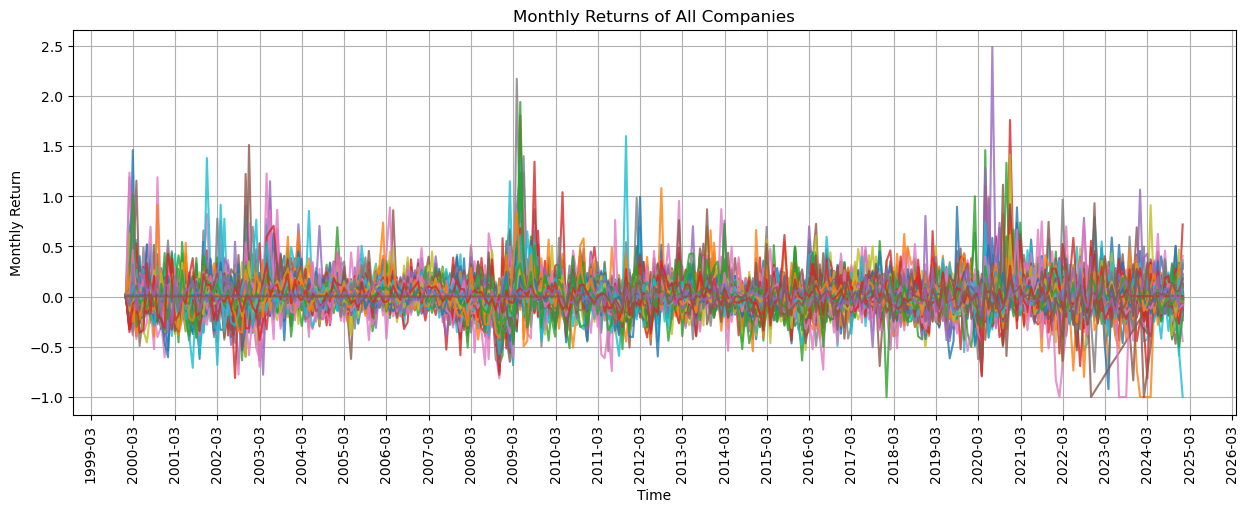

In [14]:
# Plot the monthly return of each company using cleaned dataset
fig, ax = plt.subplots(figsize=(15, 5))

for index, row in temp2.iterrows():
    plt.plot(row, label=index, alpha=0.8)

plt.title("Monthly Returns of All Companies")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("Monthly Return")
plt.grid(True)
plt.show()


In [15]:
for index, row in R_m_filled.iterrows():
    if any(row.iloc[2:] > 2.0):
        print(f"Company {row.iloc[1]} contains a monthly return over 2.0")

Company GB00B3DGH821 contains a monthly return over 2.0
Company IE00BD1RP616 contains a monthly return over 2.0


##### Clean MC_m_eur

In [16]:
temp_mc = MC_m_eur.iloc[:, 2:].copy()
temp_mc = fill_na(temp_mc)
temp2_mc = temp_mc.astype(float).interpolate(method="linear", axis=1)

In [17]:
temp2_mc.isna().sum().sum()

0

In [18]:
# extract 2014-2024
temp3_mc = temp2_mc.loc[:, (temp2_mc.columns >= pd.Timestamp("2014-01-01")) & (temp2_mc.columns <= pd.Timestamp("2024-12-31"))].copy()

# Q1

## Return & Volatility

In [19]:
# calculate annualized average return and annualized volatility
ann_avg_r = []
ann_vol = []

for index, row in temp3.iterrows():
     # aar = (np.prod(1 + row) ** (12 / len(row))) - 1
     aar = row.mean() * 12
     ann_avg_r.append(aar)
     ann_vol.append(row.std() * np.sqrt(12))


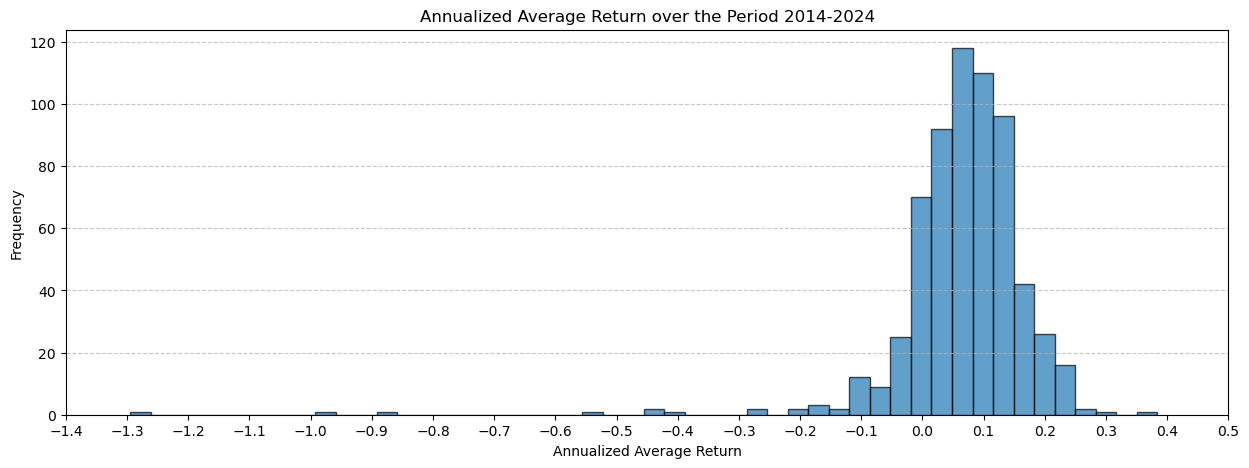

In [20]:
# plot the histogram of annualized average return
plt.figure(figsize = (15, 5))
plt.hist(ann_avg_r, bins=50, edgecolor="black", alpha=0.7)
plt.title("Annualized Average Return over the Period 2014-2024")
plt.xlabel("Annualized Average Return")
plt.ylabel("Frequency")
plt.xticks(np.arange(-1.4, 0.6, step=0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

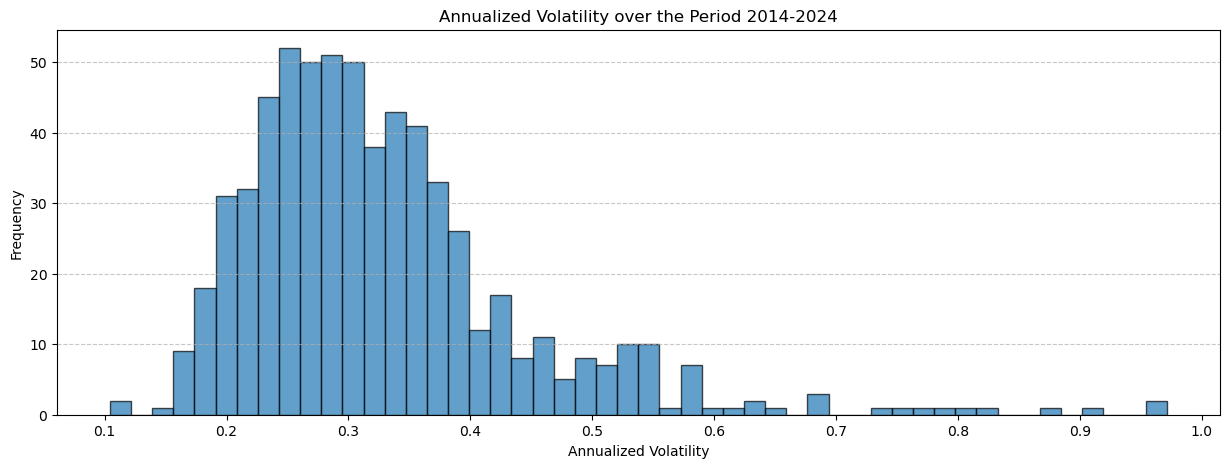

In [21]:
# plot the histogram of annualized volatility
plt.figure(figsize = (15, 5))
plt.hist(ann_vol, bins=50, edgecolor="black", alpha=0.7)
plt.title("Annualized Volatility over the Period 2014-2024")
plt.xlabel("Annualized Volatility")
plt.ylabel("Frequency")
plt.xticks(np.arange(0.1, 1.1, step=0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Correlation

In [22]:
# Compute the correlation between individual average return and volatilities in the corss section
df_corr = pd.DataFrame({'ann_avg_r': ann_avg_r, 'ann_vol': ann_vol})
correlation = df_corr.corr().iloc[0, 1]
print(correlation)

-0.3974043643583484


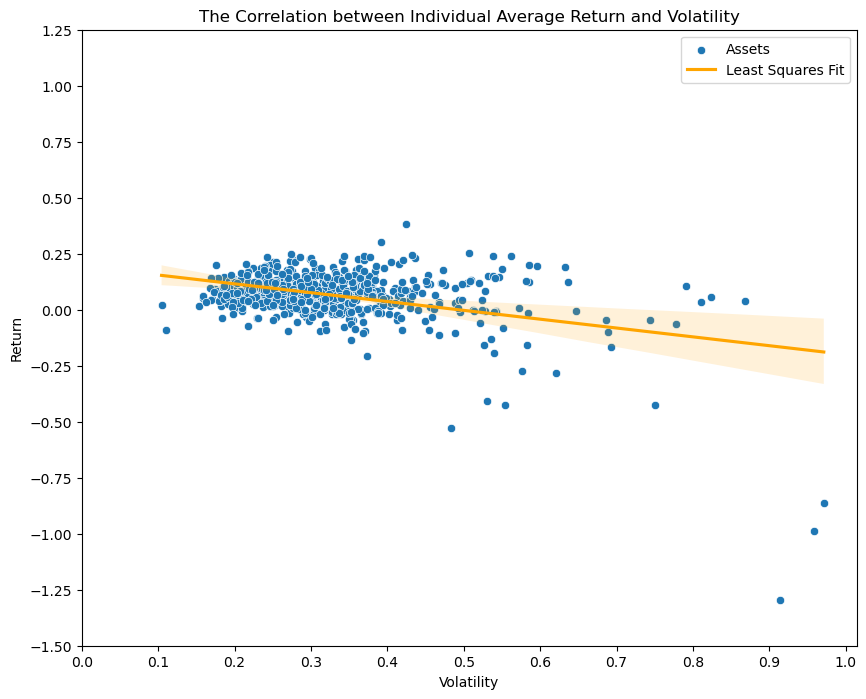

In [23]:
plt.figure(figsize=(10, 8))

sns.scatterplot(x=ann_vol, y=ann_avg_r)
sns.regplot(x=ann_vol, y=ann_avg_r, scatter=False, color="orange")

plt.title("The Correlation between Individual Average Return and Volatility")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(-1.5, 1.5, step=0.25))
plt.legend(['Assets', 'Least Squares Fit'])
plt.show()


# Q2

## Portfolio 1: Equally weighted portfolio

In [24]:
R_m_p1 = temp3.mean(axis=0)

In [25]:
# annualized average return
# ann_avg_r_p1 = (np.prod(1 + R_m_p1) ** (12 / len(R_m_p1))) - 1 
ann_avg_r_p1 = R_m_p1.mean() * 12
ann_avg_r_p1

0.0651277364571888

In [26]:
# annualized volatility
ann_vol_p1 = R_m_p1.std() * np.sqrt(12)
ann_vol_p1

0.1875906125992742

In [27]:
# Sharpe ratio
R_m_p1 = pd.DataFrame(R_m_p1)
excess_r_p1 = R_m_p1 - RF_m_temp

# vol_p1 = np.std(R_m_p1, axis=0)[0]

# sr_m_p1 = excess_r_p1 / vol_p1 # monthly sharpe ratio

# ann_sr_p1 = sr_m_p1 * np.sqrt(12) # annualized sharpe ratio

ann_sr_p1 = (excess_r_p1.mean() * 12 / (excess_r_p1.std() * np.sqrt(12)))[0]
ann_sr_p1

0.2656242213153573

In [28]:
# minium return & maximum return
R_m_p1_min = R_m_p1.min()[0]
R_m_p1_max = R_m_p1.max()[0]
print(f"Minimum return: {R_m_p1_min}")
print(f"Maximum return: {R_m_p1_max}")

Minimum return: -0.23148306723755774
Maximum return: 0.23229986979698006


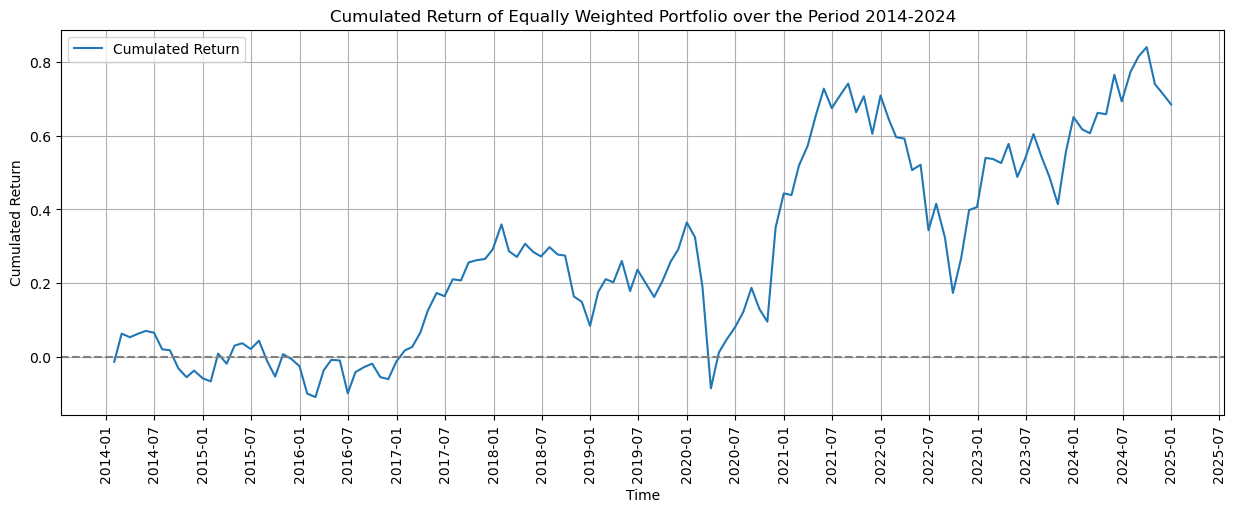

In [29]:
# cumulated returns
cum_r_m_p1 = np.cumprod(1 + R_m_p1) - 1

plt.figure(figsize=(15, 5))
plt.plot(cum_r_m_p1, label="Cumulated Return")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-01-01"))
plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cumulated Return")
plt.title("Cumulated Return of Equally Weighted Portfolio over the Period 2014-2024")
plt.legend()
plt.grid(True)
plt.show()


## Portfolio 2: Market-cap weighted portfolio

In [30]:
mc_weight_p2 = temp3_mc.div(temp3_mc.sum(axis=0), axis=1)
R_m_p2 = (temp3 * mc_weight_p2).sum(axis=0)

In [31]:
# annualized average return
# ann_avg_r_p2 = (np.prod(1 + R_m_p2) ** (12 / len(R_m_p2))) - 1 
ann_avg_r_p2 = R_m_p2.mean() * 12
ann_avg_r_p2

0.10503398643340538

In [32]:
# annualized volatility
ann_vol_p2 = R_m_p2.std() * np.sqrt(12)
ann_vol_p2

0.16024019605276266

In [33]:
# Sharpe ratio
R_m_p2 = pd.DataFrame(R_m_p2)
excess_r_p2 = R_m_p2 - RF_m_temp
# vol_p2 = np.std(R_m_p2, axis=0)[0]
# sr_m_p2 = excess_r_p2 / vol_p2 # monthly sharpe ratio

# ann_sr_p2 = sr_m_p2 * np.sqrt(12) # annualized sharpe ratio

ann_sr_p2 = (excess_r_p2.mean() * 12 / (excess_r_p2.std() * np.sqrt(12)))[0]
ann_sr_p2

0.5604802089115809

In [34]:
# minium return & maximum return
R_m_p2_min = R_m_p2.min()[0]
R_m_p2_max = R_m_p2.max()[0]
print(f"Minimum return: {R_m_p2_min}")
print(f"Maximum return: {R_m_p2_max}")

Minimum return: -0.13213548028959876
Maximum return: 0.19232094721100984


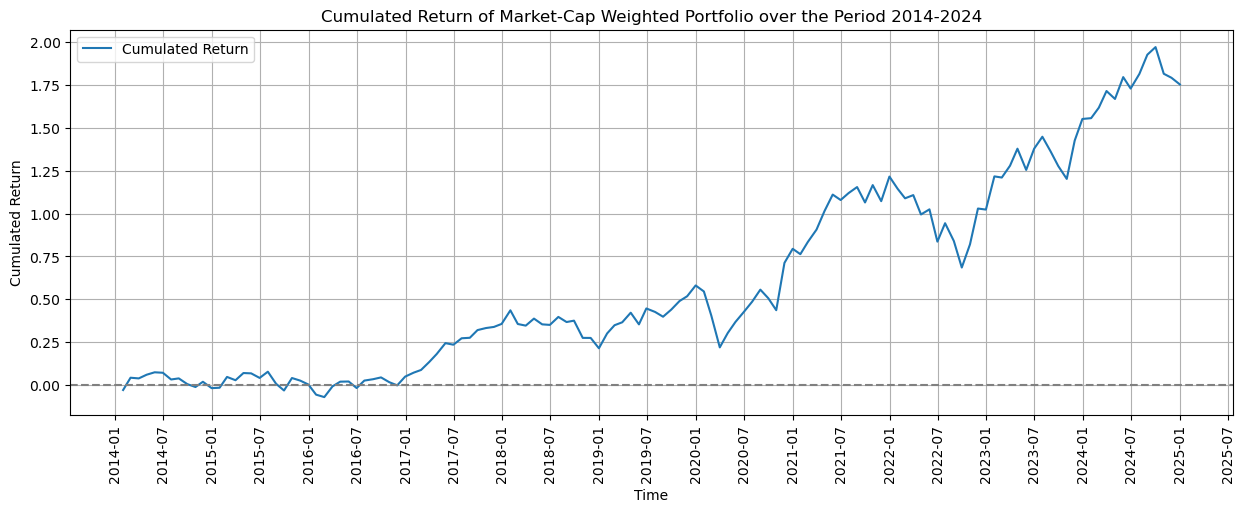

In [35]:
# cumulated returns
cum_r_m_p2 = np.cumprod(1 + R_m_p2) - 1

plt.figure(figsize=(15, 5))
plt.plot(cum_r_m_p2, label="Cumulated Return")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-01-01"))
plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cumulated Return")
plt.title("Cumulated Return of Market-Cap Weighted Portfolio over the Period 2014-2024")
plt.legend()
plt.grid(True)
plt.show()

## Comparison

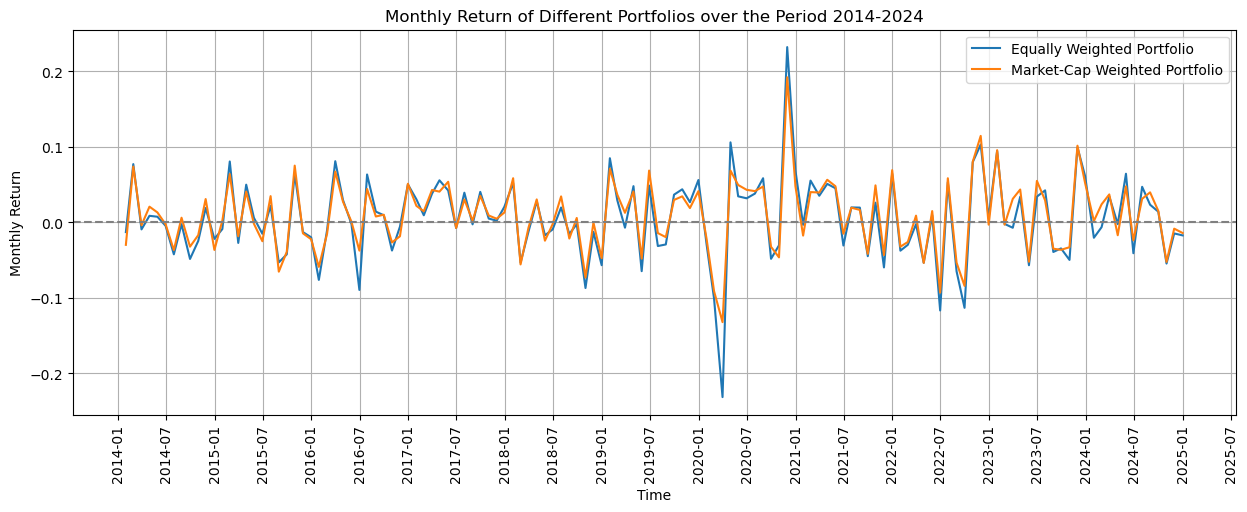

In [36]:
# plot monthly return together for comparison
plt.figure(figsize=(15, 5))
plt.plot(R_m_p1, label="Equally Weighted Portfolio")
plt.plot(R_m_p2, label="Market-Cap Weighted Portfolio")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-01-01"))
plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Monthly Return")
plt.title("Monthly Return of Different Portfolios over the Period 2014-2024")
plt.legend()
plt.grid(True)
plt.show()

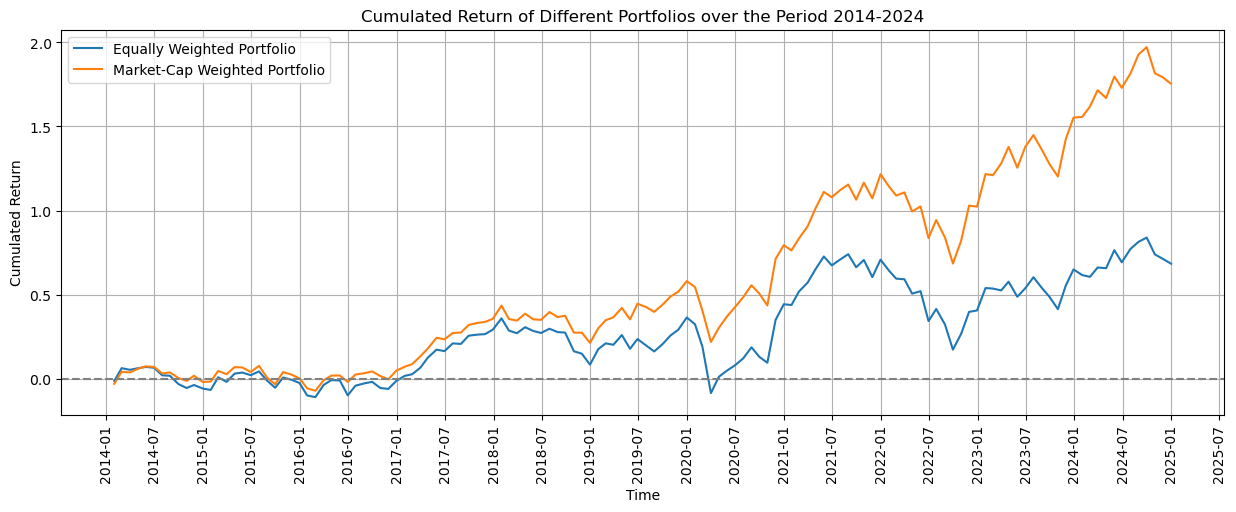

In [37]:
# plot cumulated return together for comparison
plt.figure(figsize=(15, 5))
plt.plot(cum_r_m_p1, label="Equally Weighted Portfolio")
plt.plot(cum_r_m_p2, label="Market-Cap Weighted Portfolio")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-01-01"))
plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cumulated Return")
plt.title("Cumulated Return of Different Portfolios over the Period 2014-2024")
plt.legend()
plt.grid(True)
plt.show()

# Q3

In [38]:
# compute the expected return
expected_r = temp3.mean(axis=1)
ann_expected_r = expected_r.values.reshape((-1, 1)) * 12

In [39]:
# compute the population covariance matrix 
pop_cov = temp3.T.cov(ddof=0)
ann_pop_cov = pop_cov * 12 

# N > T -> correct the non-positive denifite singular matrix
t = temp3.shape[1]
ann_pop_cov_fixed = LedoitWolf().fit(temp3.T).covariance_ * (t-1) / t * 12

In [40]:
# compute the minimum variance portfolio
n = len(temp3)

alpha1 = cp.Variable((n, 1))
objective_min_var = cp.Minimize(cp.quad_form(alpha1, ann_pop_cov_fixed))
constraints_min_var = [cp.sum(alpha1) == 1, alpha1 >= 0]

prob_min_var = cp.Problem(objective_min_var, constraints_min_var)
prob_min_var.solve(solver=cp.GUROBI)

min_var_weights = alpha1.value
min_var_return = np.matmul(min_var_weights.T, ann_expected_r)[0][0]
min_var_return

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2630708
Academic license 2630708 - for non-commercial use only - registered to yo___@epfl.ch


0.020321181179118943

In [41]:
# compute the maximum return portfolio
alpha2 = cp.Variable((n, 1))
objective_max_r = cp.Maximize(cp.matmul(alpha2.T, ann_expected_r))
constraints_max_r = [cp.sum(alpha2) == 1, alpha2 >= 0]

prob_max_r = cp.Problem(objective_max_r, constraints_max_r)
prob_max_r.solve(solver=cp.GUROBI)

max_r_weights = alpha2.value 
max_r_return = np.matmul(max_r_weights.T, ann_expected_r)[0][0]
max_r_return

0.3839995896689018

In [42]:
# build the efficient frontier
target_returns = np.linspace(min_var_return, max_r_return, num=20)
efficient_frontier = []

for mu_p in tqdm(target_returns):
    alpha3 = cp.Variable((n, 1))
    objective_ef = cp.Minimize(cp.quad_form(alpha3, ann_pop_cov_fixed))
    constraints_ef = [
        cp.matmul(alpha3.T, ann_expected_r) >= mu_p,
        cp.sum(alpha3) == 1,
        alpha3 >= 0,
    ]
    prob_ef = cp.Problem(objective_ef, constraints_ef)
    prob_ef.solve(solver=cp.GUROBI)

    vol_ef = np.sqrt(alpha3.value.T @ ann_pop_cov @ alpha3.value)
    efficient_frontier.append(
        {"mu": mu_p, "vol": vol_ef[0][0], "weight": alpha3.value.flatten()}
    )

100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


In [43]:
mus = [item["mu"] for item in efficient_frontier]
vols = [item["vol"] for item in efficient_frontier]
weights = [item["weight"] for item in efficient_frontier]

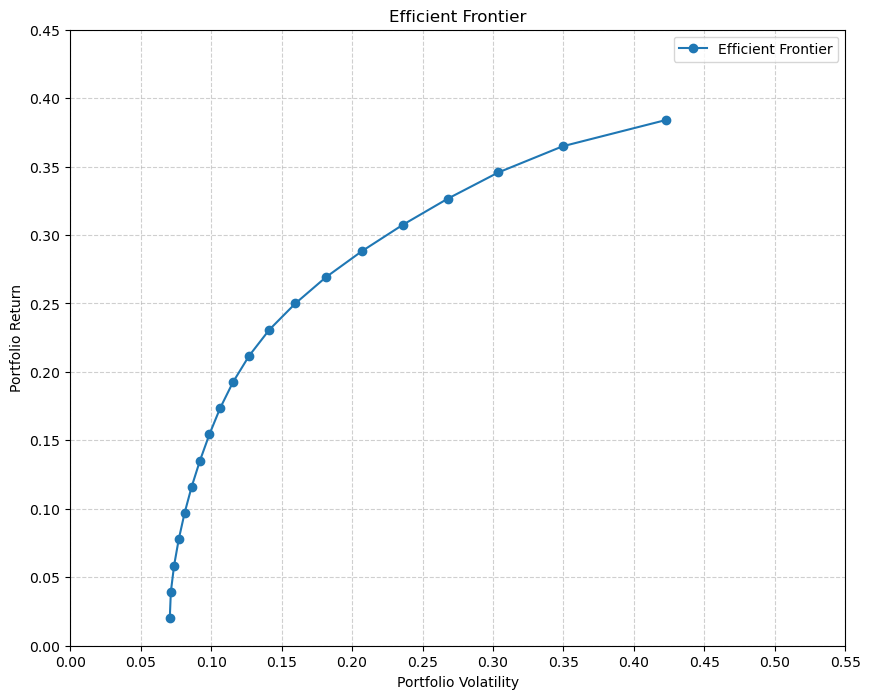

In [44]:
# Plot the efficient frontier alone
plt.figure(figsize=(10, 8))
plt.plot(vols, mus, 'o-', label="Efficient Frontier")
plt.title('Efficient Frontier')
plt.xlabel("Portfolio Volatility")
plt.ylabel("Portfolio Return")
plt.xticks(np.arange(0, 0.6, step=0.05))
plt.yticks(np.arange(0, 0.5, step=0.05))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [45]:
# compute the ex-post performance
R_m_p3 = []

for weight in weights:
    weight = weight.reshape((1, -1))
    ex_post_r = weight @ temp3.values
    R_m_p3.append(ex_post_r)


In [46]:
# check whether the weights are positive
[np.sum(weight < 0) for weight in weights]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [47]:
# compute the ex-post annualized average return, the ex-post annualized volatility, and the ex-post annualized Sharpe ratio
ann_avg_r_ef_post = []
ann_vol_ef_post = []
ann_sp_ef_post = []

for portfolio in R_m_p3:
    r = portfolio.mean() * 12
    ann_avg_r_ef_post.append(r)
    vol = portfolio.std() * np.sqrt(12)
    ann_vol_ef_post.append(vol)
    e_r = portfolio - RF_m_temp.values
    sp = (e_r.mean() * 12 / (e_r.std() * np.sqrt(12)))
    ann_sp_ef_post.append(sp)

print(f"Ex-post annualized average return: {ann_avg_r_ef_post}")
print(f"Ex-post annualized volatility: {ann_vol_ef_post}")
print(f"Ex-post annualized Sharpe ratio: {ann_sp_ef_post}")


Ex-post annualized average return: [0.020378792625302143, 0.03946215011549787, 0.05860311897946274, 0.07774408784261616, 0.09688505669008879, 0.11602602552558791, 0.13516699439175814, 0.15430796340448302, 0.17344893214824014, 0.1925899009963971, 0.21173086985881373, 0.2308718386908678, 0.2500128075995352, 0.26915377646516714, 0.28829474532976634, 0.30743571419791516, 0.32657668307392296, 0.3457176519334302, 0.3648586208113613, 0.38399958966892855]
Ex-post annualized volatility: [0.07062334119468168, 0.07138192443506318, 0.0736757374450716, 0.0769770734417174, 0.08110925173048374, 0.08610459876412974, 0.09200923767947934, 0.09870335098865436, 0.10630225392659344, 0.11550426349543326, 0.12687421572304314, 0.1412872908091381, 0.15971068234400143, 0.1813652656861657, 0.20706019603277784, 0.23591355385126614, 0.26788770491175634, 0.30374144643355294, 0.3494651217496697, 0.4225806192810601]
Ex-post annualized Sharpe ratio: [0.07209368260776772, 0.337926707087201, 0.58658054166481, 0.80960763

In [48]:
# compute the ex-ante Sharpe ratio
ann_rf = (RF_m_temp.mean() * 12)[0]
ann_sp_ef_ante = []

for item in efficient_frontier:
    mu = item["mu"]
    vol = item["vol"]
    sp_ante = (mu - ann_rf) / vol
    ann_sp_ef_ante.append(sp_ante)

print(f"Ex-ante return: {mus}")
print(f"Ex-ante volatility: {vols}")
print(f"Ex-ante annualized Sharpe ratio: {ann_sp_ef_ante}")

# Note: It makes sense that the ex-ante and ex-post results are super close, because the calculations of expected return and covariance matrix are based on the real data during sample period rather than predictions.

Ex-ante return: [0.020321181179118943, 0.03946215004700225, 0.05860311891488556, 0.07774408778276887, 0.09688505665065217, 0.11602602551853547, 0.1351669943864188, 0.1543079632543021, 0.1734489321221854, 0.1925899009900687, 0.211730869857952, 0.23087183872583533, 0.25001280759371863, 0.26915377646160193, 0.2882947453294853, 0.3074357141973686, 0.3265766830652519, 0.3457176519331352, 0.3648586208010185, 0.3839995896689018]
Ex-ante volatility: [0.0706233411946817, 0.07138192443506318, 0.07367573744507161, 0.07697707344171746, 0.08110925173048372, 0.08610459876412975, 0.09200923767947933, 0.09870335098865438, 0.10630225392659343, 0.11550426349543326, 0.12687421572304317, 0.14128729080913816, 0.1597106823440014, 0.18136526568616576, 0.20706019603277784, 0.23591355385126614, 0.26788770491175645, 0.30374144643355283, 0.3494651217496698, 0.42258061928105695]
Ex-ante annualized Sharpe ratio: [0.07148421217391854, 0.33887322267810704, 0.5881229444695132, 0.8115580096370026, 1.0062024693448393, 

In [49]:
# Compare the ex-ante and ex-post performance in a table
portfolio_name = np.arange(1, 21, 1)
ante_post_comparison = pd.DataFrame(
    {'Portfolio': portfolio_name,
     'Ex-Ante Return': mus,
     'Ex_Ante Volatility': vols,
     'Ex-Ante Sharpe Ratio': ann_sp_ef_ante,
     'Ex-Post Return': ann_avg_r_ef_post,
     'Ex-Post Volatility': ann_vol_ef_post,
     'Ex-Post Sharpe ratio': ann_sp_ef_post
    }
)

ante_post_comparison

,Portfolio,Ex-Ante Return,Ex_Ante Volatility,Ex-Ante Sharpe Ratio,Ex-Post Return,Ex-Post Volatility,Ex-Post Sharpe ratio
0,1,0.020321,0.070623,0.071484,0.020379,0.070623,0.072094
1,2,0.039462,0.071382,0.338873,0.039462,0.071382,0.337927
2,3,0.058603,0.073676,0.588123,0.058603,0.073676,0.586581
3,4,0.077744,0.076977,0.811558,0.077744,0.076977,0.809608
4,5,0.096885,0.081109,1.006202,0.096885,0.081109,1.004024
5,6,0.116026,0.086105,1.170127,0.116026,0.086105,1.167878
6,7,0.135167,0.092009,1.303068,0.135167,0.092009,1.300873
7,8,0.154308,0.098703,1.408617,0.154308,0.098703,1.406555
8,9,0.173449,0.106302,1.487985,0.173449,0.106302,1.486107
9,10,0.192590,0.115504,1.535157,0.192590,0.115504,1.533515


In [50]:
# Compare the performance in terms of ex-ante Sharpe ratio & ex-post Sharpe ratio
print(f"Index of the portfolio with the highest performance in terms of ex-ante Sharpe ratio: {np.argmax(ann_sp_ef_ante)}")
print(f"Index of the portfolio with the highest performance in terms of ex-post Sharpe ratio: {np.argmax(ann_sp_ef_post)}")  

# From the output, we can see that the 11th portfolio has the best performance

Index of the portfolio with the highest performance in terms of ex-ante Sharpe ratio: 10
Index of the portfolio with the highest performance in terms of ex-post Sharpe ratio: 10


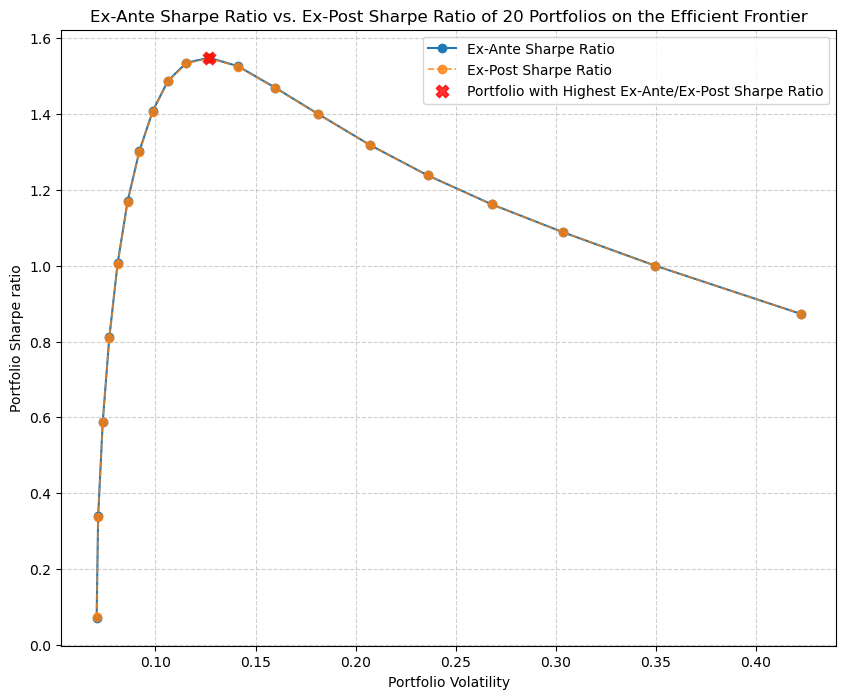

In [51]:
plt.figure(figsize=(10, 8))
plt.plot(vols, ann_sp_ef_ante, 'o-', label="Ex-Ante Sharpe Ratio")
plt.plot(ann_vol_ef_post, ann_sp_ef_post, 'o--', label="Ex-Post Sharpe Ratio", alpha=0.8, linewidth=1.2)
plt.scatter(ann_vol_ef_post[10], ann_sp_ef_post[10], color="red", marker="X", s=80, label="Portfolio with Highest Ex-Ante/Ex-Post Sharpe Ratio", alpha=0.8, zorder=3)
plt.title('Ex-Ante Sharpe Ratio vs. Ex-Post Sharpe Ratio of 20 Portfolios on the Efficient Frontier')
plt.xlabel("Portfolio Volatility")
plt.ylabel("Portfolio Sharpe ratio")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

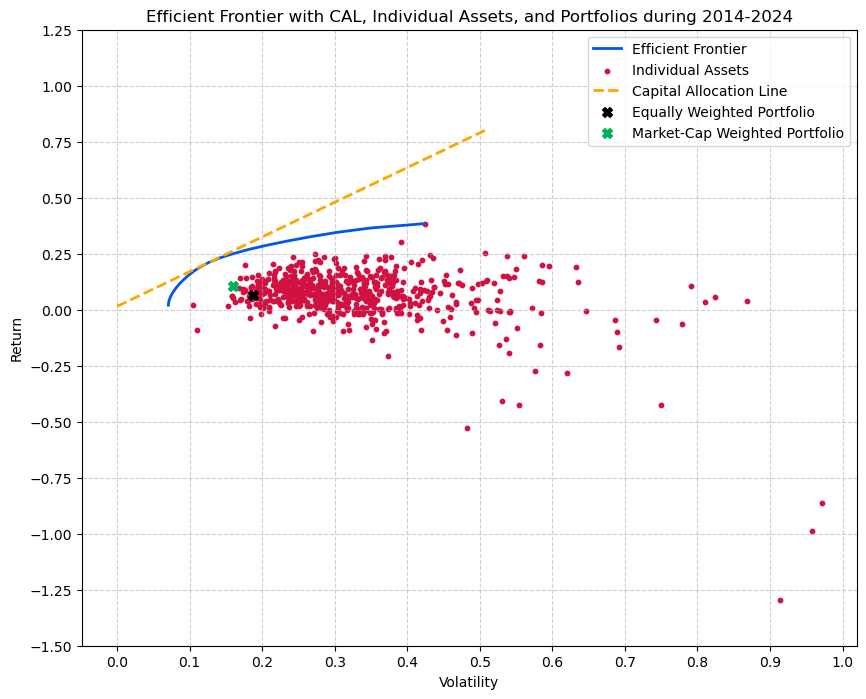

In [52]:
cal_slope = np.max(ann_sp_ef_ante)
cal_vol = np.linspace(0, max(vols) * 1.2, 100)
cal_r = ann_rf + cal_slope * cal_vol

plt.figure(figsize=(10, 8))
plt.plot(vols, mus, label="Efficient Frontier", color="#0057e7", linestyle="-", linewidth=2)
plt.scatter(ann_vol, ann_avg_r, color="#d11141", marker="o", label="Individual Assets", s=10)
plt.plot(cal_vol, cal_r, color="orange", linestyle="--", label="Capital Allocation Line", linewidth=2)
plt.scatter(ann_vol_p1, ann_avg_r_p1, color="black", marker="X", s=50, label="Equally Weighted Portfolio")
plt.scatter(ann_vol_p2, ann_avg_r_p2, color="#00b159", marker="X", s=50, label="Market-Cap Weighted Portfolio")

plt.title('Efficient Frontier with CAL, Individual Assets, and Portfolios during 2014-2024')
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(-1.5, 1.5, step=0.25))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Q4

In [53]:
# compute the expected returns and the covariance matrix (out of sample) for 2014-2024 (yearly)
mu1424 = (temp0424.T.rolling(window=120, step=12).mean() * 12).T #annualized expected return
mu1424 = mu1424.loc[:, mu1424.columns >= pd.Timestamp("2014-01-01")].copy()

tau = 120
step = 12
start_index = [i for i in range(0, 121, 12)]
weights_rw = []
R_m_poos = []

# compute the optimal weight
for start in start_index:
    df = temp0424.iloc[:, start:(start+tau)]
    cov_df = df.T.cov(ddof=0) * 12 # annualized covariance matrix
    cov_df_fixed = LedoitWolf().fit(df.T).covariance_ * (tau - 1) / tau * 12 #fixed annualized covariance matrix

    alpha_df = cp.Variable((n,1))
    objective_rw = cp.Minimize(cp.quad_form(alpha_df, cov_df_fixed))
    constraints_rw = [cp.sum(alpha_df) == 1, alpha_df >= 0]

    prob_rw = cp.Problem(objective_rw, constraints_rw)
    prob_rw.solve(solver=cp.GUROBI)

    alpha_df = alpha_df.value.reshape((1, -1))
    weights_rw.append(alpha_df)

    # compute the portfolio return for the Jan of each year
    r_p_jan = (alpha_df @ temp3.iloc[:, start].values.reshape((-1, 1)))[0][0]
    R_m_poos.append(r_p_jan)

    alpha_df_temp = alpha_df.copy()
    r_p_temp = r_p_jan
    # update the monthly weight
    for i in range(1, 12):
        r = temp3.iloc[:, start+i-1].values.reshape((-1, 1))
        update_coef = ((r + 1) / (1 + r_p_temp)).T  # shape: (1, n)
        alpha_df_temp = alpha_df_temp * update_coef
        weights_rw.append(alpha_df_temp)

        r_p_temp = (alpha_df_temp @ temp3.iloc[:, start+i].values.reshape((-1, 1)))[0][0]
        R_m_poos.append(r_p_temp)


In [54]:
# a time series of ex-post portfolio monthly return
R_m_poos

[-0.01194167595822955,
 0.04473264503331301,
 0.0016658087142907754,
 0.0017281577816478997,
 -0.007380357438716916,
 -0.004792052978905725,
 -0.0008861486050618024,
 0.0006485509754648741,
 -0.03964346302695823,
 -0.014918115507359003,
 -0.006406630700241155,
 -0.01757880853851861,
 -0.013099500621004307,
 0.07342476897993797,
 -0.02751316502338979,
 0.021998791410314716,
 -0.0009391044469505671,
 -0.008678721959029197,
 0.01808999055156776,
 -0.02403978185284774,
 -0.003966000068166524,
 0.03192101742414804,
 -0.003252274338049482,
 -0.0146347557749581,
 -0.01639480770899757,
 -0.009218775841885404,
 0.023906822011966575,
 0.008331436915465817,
 3.4153221608345698e-06,
 -0.0030144449911666993,
 0.01646507008793312,
 -0.0077314763746023024,
 0.011270184573100188,
 -0.006046543675694893,
 0.0019120311473309211,
 0.006534485513282983,
 0.0034136471298502886,
 0.011610409073620114,
 0.009003771335492699,
 0.01834707613108806,
 0.017749446584447166,
 0.00913842484664075,
 0.01201352629214

In [55]:
# Annualized average return
ann_avg_r_poos = np.mean(R_m_poos) * 12
ann_avg_r_poos

0.01904593362641105

In [56]:
# Annualized volatility
ann_vol_poos = np.std(R_m_poos) * np.sqrt(12)
ann_vol_poos

0.09846611615192742

In [57]:
# Sharpe Ratio
R_m_poos = pd.DataFrame(R_m_poos)
R_m_poos.index = RF_m_temp.index
excess_r_poos = R_m_poos - RF_m_temp

ann_sr_poos = (excess_r_poos.mean() * 12 / (excess_r_poos.std() * np.sqrt(12)))[0]
ann_sr_poos

0.03815300911163337

In [58]:
# minimum return & maximum return
R_m_poos_min = R_m_poos.min()[0]
R_m_poos_max = R_m_poos.max()[0]
print(f"Minimum return: {R_m_poos_min}")
print(f"Maximum return: {R_m_poos_max}")

Minimum return: -0.10928241350041429
Maximum return: 0.08984919185858642


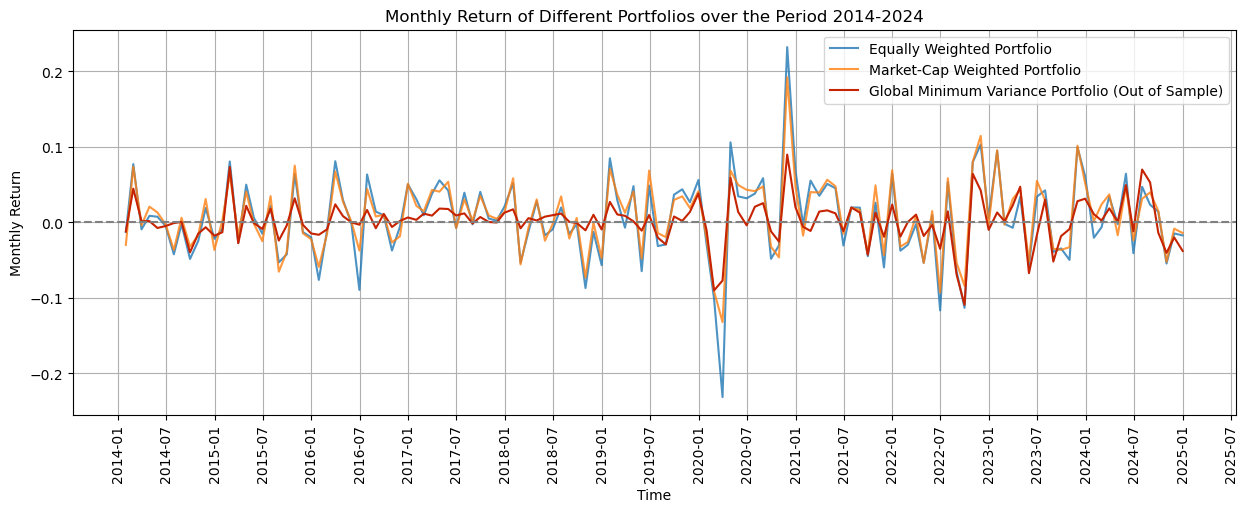

In [59]:
# plot monthly return together for comparison
plt.figure(figsize=(15, 5))
plt.plot(R_m_p1, label="Equally Weighted Portfolio", alpha=0.8)
plt.plot(R_m_p2, label="Market-Cap Weighted Portfolio", alpha=0.8)
plt.plot(R_m_poos, color="#C62300", label="Global Minimum Variance Portfolio (Out of Sample)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-01-01"))
plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Monthly Return")
plt.title("Monthly Return of Different Portfolios over the Period 2014-2024")
plt.legend()
plt.grid(True)
plt.show()

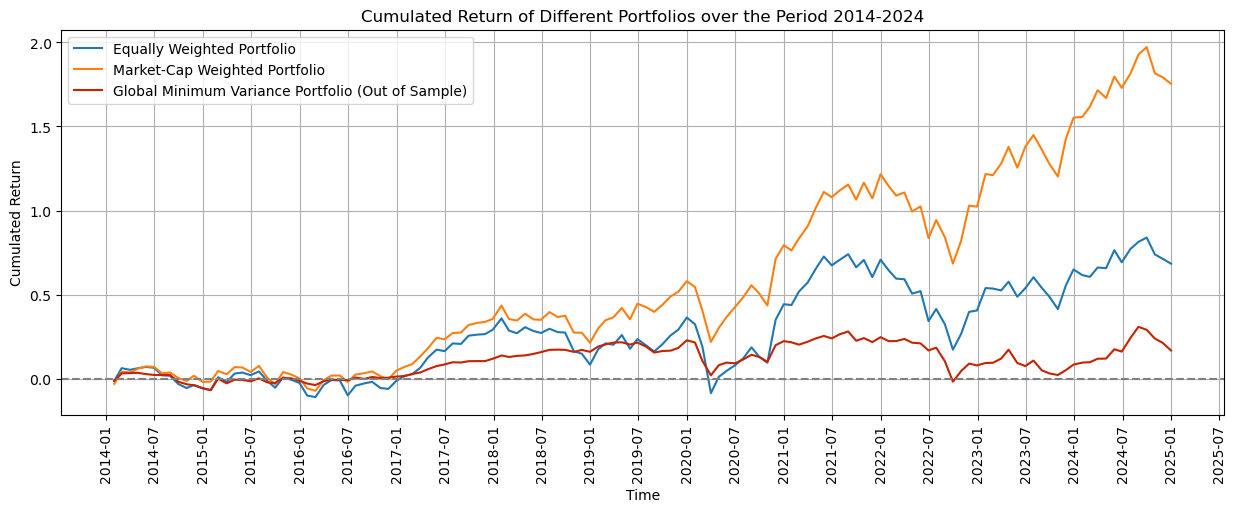

In [60]:
cum_r_m_poos = np.cumprod(1 + R_m_poos) - 1

# plot cumulated return together for comparison
plt.figure(figsize=(15, 5))
plt.plot(cum_r_m_p1, label="Equally Weighted Portfolio")
plt.plot(cum_r_m_p2, label="Market-Cap Weighted Portfolio")
plt.plot(cum_r_m_poos, color="#C62300", label="Global Minimum Variance Portfolio (Out of Sample)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-01-01"))
plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cumulated Return")
plt.title("Cumulated Return of Different Portfolios over the Period 2014-2024")
plt.legend()
plt.grid(True)
plt.show()